In [1]:
# --- 1. SETUP AND INSTALLATIONS ---
# This cell installs all required packages and sets up directories.
# It should be run once at the beginning of each session.

!pip install torch pydeck h5py pandas numpy scikit-learn -q matplotlib ipywidgets tables tqdm seaborn

In [2]:


import os
import pickle
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pydeck as pdk
import inspect
import json
import ipywidgets as widgets
from IPython.display import display, clear_output
from tqdm.notebook import tqdm
import time
import networkx as nx

# --- 2. GLOBAL CONFIGURATION ---
# Define all major parameters and paths in one place for easy modification.

# Core Parameters
HISTORY_LEN = 12
HORIZON = 12
SEED = 42

# File Paths (IMPORTANT: Update if your local path is different)
DRIVE_DATA_PATH = r'D:\IPYNB Notebooks\dlp_ese\Dataset_DP_ESE'
DRIVE_OUTPUT_PATH = r'D:\IPYNB Notebooks\dlp_ese\output'
DRIVE_TUNING_PATH = os.path.join(DRIVE_OUTPUT_PATH, 'tuning_results')
SCALER_SAVE_PATH = os.path.join(DRIVE_OUTPUT_PATH, 'scaler.pkl')

# Visualization
MAPBOX_API_KEY = ""

# --- 3. INITIALIZE ENVIRONMENT ---
# Create directories, set the device (GPU/CPU), and fix the random seed.

if not os.path.exists(DRIVE_OUTPUT_PATH):
    os.makedirs(DRIVE_OUTPUT_PATH)
if not os.path.exists(DRIVE_TUNING_PATH):
    os.makedirs(DRIVE_TUNING_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def set_seed(seed):
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

print(f"Output directory: {DRIVE_OUTPUT_PATH}")
print(f"Tuning results will be saved in: {DRIVE_TUNING_PATH}")
print(f"Using device: {device}")

Output directory: D:\IPYNB Notebooks\dlp_ese\output
Tuning results will be saved in: D:\IPYNB Notebooks\dlp_ese\output\tuning_results
Using device: cuda


In [3]:
# --- 1. LOAD RAW DATA ---
try:
    df_traffic = pd.read_hdf(os.path.join(DRIVE_DATA_PATH, 'metr-la.h5'))
    with open(os.path.join(DRIVE_DATA_PATH, 'adj_mx.pkl'), 'rb') as f:
        sensor_ids_list, _, adj_matrix = pickle.load(f, encoding='latin1')
    df_locations = pd.read_csv(os.path.join(DRIVE_DATA_PATH, 'graph_sensor_locations.csv'))
except FileNotFoundError as e:
    print(f"ERROR: File not found at '{e.filename}'. Please verify your DRIVE_DATA_PATH.")
    raise e

# --- 2. PREPARE GRAPH AND LOCATIONS ---
def normalize_adj(adj):
    adj = adj + np.eye(adj.shape[0])
    d = np.array(adj.sum(1))
    d_inv_sqrt = np.power(d, -0.5).flatten()
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt)
    return (d_mat_inv_sqrt @ adj @ d_mat_inv_sqrt).astype(np.float32)

adj_norm = torch.tensor(normalize_adj(adj_matrix), device=device)
df_locations['sensor_ids'] = df_locations['sensor_id'].astype(str)
df_locations = df_locations.sort_values(by='sensor_id').reset_index(drop=True) # Ensure consistent order

# --- 3. SCALE AND SPLIT TIME SERIES DATA ---
traffic_values = df_traffic.values
train_size = int(len(traffic_values) * 0.7)
val_size = int(len(traffic_values) * 0.1)
train_data, val_data, test_data = traffic_values[:train_size], traffic_values[train_size:train_size + val_size], traffic_values[train_size + val_size:]

scaler = StandardScaler()
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)
with open(SCALER_SAVE_PATH, 'wb') as f:
    pickle.dump(scaler, f)

# --- 4. CREATE SEQUENCED DATASETS AND DATALOADERS ---
def create_dataset(data, lookback, horizon):
    X, y = [], []
    for i in range(len(data) - lookback - horizon + 1):
        X.append(data[i:i + lookback])
        y.append(data[i + lookback:i + lookback + horizon])
    X = np.array(X)[..., np.newaxis]
    y = np.transpose(np.array(y), (0, 2, 1))
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)

X_train, y_train = create_dataset(train_data_scaled, HISTORY_LEN, HORIZON)
X_val, y_val = create_dataset(val_data_scaled, HISTORY_LEN, HORIZON)
X_test, y_test = create_dataset(test_data_scaled, HISTORY_LEN, HORIZON)

class TrafficDataset(Dataset):
    def __init__(self, X, y): self.X, self.y = X, y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

train_dataset, val_dataset, test_dataset = TrafficDataset(X_train, y_train), TrafficDataset(X_val, y_val), TrafficDataset(X_test, y_test)
print(f"Data loaded and processed. Train samples: {len(train_dataset)}")

Data loaded and processed. Train samples: 23967


--- Statistical Summary of Training Data ---


,0,1,2,3,4,5,6,7,8,9,...,197,198,199,200,201,202,203,204,205,206
count,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,...,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000,23990.000000
mean,57.061794,60.932824,61.176556,50.061579,47.008567,52.006649,55.272628,56.865381,56.530177,53.469050,...,38.331863,58.882876,51.116157,60.251110,59.094880,56.734678,62.939158,55.314459,59.673987,52.138578
std,20.063672,14.978568,17.476050,15.115344,18.482969,16.164937,17.168220,19.187288,17.432017,22.905283,...,13.026768,19.816564,22.408949,15.152417,20.096318,18.567695,15.992347,15.508219,18.150947,20.365212
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,61.750000,63.111111,65.444444,50.555556,35.375000,50.125000,56.555556,60.857143,58.125000,51.750000,...,31.578571,64.333333,53.606250,61.750000,63.500000,60.125000,65.875000,50.875000,63.142857,55.500000
50%,65.125000,65.000000,67.333333,54.000000,46.444444,56.666667,62.333333,63.250000,62.375000,66.000000,...,43.142857,67.111111,61.777778,64.875000,66.750000,63.000000,67.625000,61.375000,66.222222,62.125000
75%,66.888889,66.333333,68.375000,58.125000,64.625000,61.250000,65.111111,65.000000,65.000000,67.666667,...,46.666667,68.428571,64.333333,66.500000,68.250000,64.750000,68.555556,64.555556,67.750000,63.444444
max,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,...,65.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000,70.000000


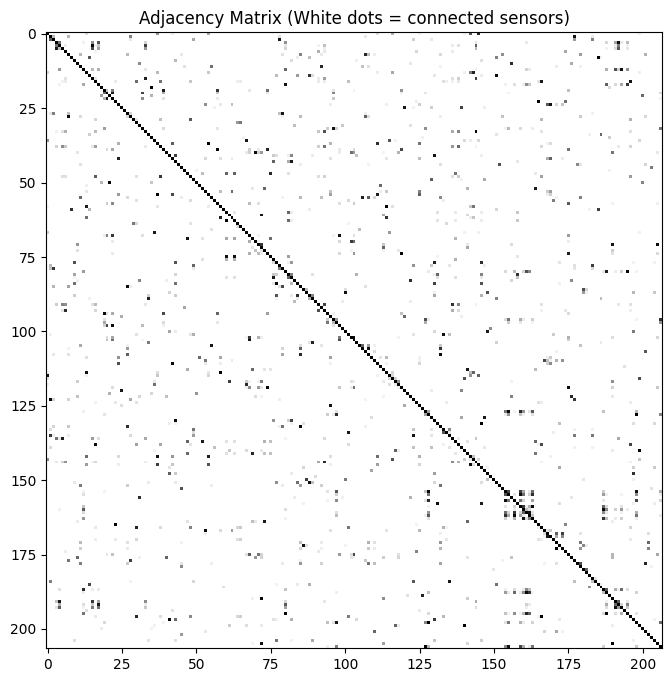

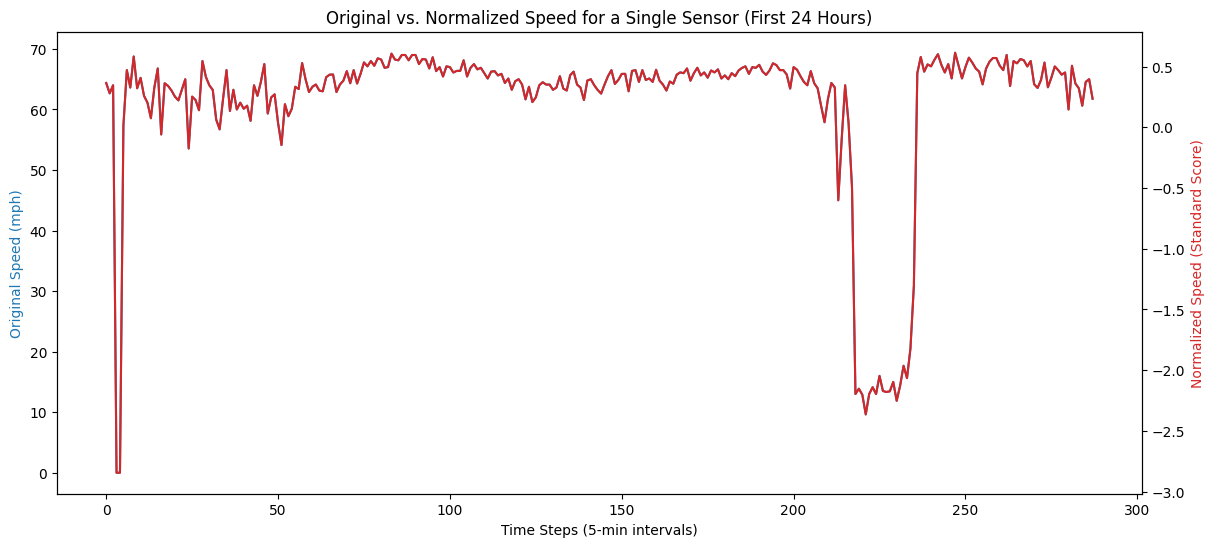

In [4]:
# --- 1. ANALYSIS OF DATA SPLITS ---
print("--- Statistical Summary of Training Data ---")
display(pd.DataFrame(train_data).describe())

# --- 2. VISUALIZATION OF THE ADJACENCY MATRIX ---
plt.figure(figsize=(8, 8))
plt.imshow(adj_matrix, cmap='Greys', interpolation='nearest')
plt.title('Adjacency Matrix (White dots = connected sensors)')
plt.show()

# --- 3. VISUALIZATION OF NORMALIZED SPEED DATA ---
fig, ax1 = plt.subplots(figsize=(14, 6))
ax1.set_xlabel('Time Steps (5-min intervals)')
ax1.set_ylabel('Original Speed (mph)', color='tab:blue')
ax1.plot(train_data[:288, 0], color='tab:blue', label='Original')
ax2 = ax1.twinx()  
ax2.set_ylabel('Normalized Speed (Standard Score)', color='tab:red')
ax2.plot(train_data_scaled[:288, 0], color='tab:red', label='Normalized')
plt.title('Original vs. Normalized Speed for a Single Sensor (First 24 Hours)')
plt.show()

In [18]:
# SEARCH_SPACE = {
#     "DSTAGNN": [
#         {'spatial_hidden': 32, 'temporal_hidden': 64, 'dropout': 0.3, 'lr': 0.001},
#         {'spatial_hidden': 64, 'temporal_hidden': 128, 'dropout': 0.3, 'lr': 0.0005},
#         {'spatial_hidden': 64, 'temporal_hidden': 128, 'dropout': 0.5, 'lr': 0.0005},
#     ],
#     "STGCN": [
#         {'out_channels': 32, 'spatial_channels': 8, 'lr': 0.001},
#         {'out_channels': 64, 'spatial_channels': 16, 'lr': 0.001},
#         {'out_channels': 64, 'spatial_channels': 16, 'lr': 0.0005},
#     ],
#     "GAT_LSTM": [
#         # Note: These runs are very slow and are skipped by default in the training cell.
#         {'spatial_hidden': 32, 'temporal_hidden': 64, 'dropout': 0.3, 'lr': 0.001},
#         {'spatial_hidden': 64, 'temporal_hidden': 128, 'dropout': 0.3, 'lr': 0.0005},
#         {'spatial_hidden': 48, 'temporal_hidden': 96, 'dropout': 0.5, 'lr': 0.0007},
#     ],
# }

# TUNING_EPOCHS = 20
# TUNING_BATCH_SIZE = 64

# train_loader = DataLoader(train_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(val_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=False)

In [5]:
SEARCH_SPACE = {
    "DSTAGNN": [
        {'spatial_hidden': 32, 'temporal_hidden': 64, 'dropout': 0.3, 'lr': 0.001},
       
    ],
    "STGCN": [
        {'out_channels': 32, 'spatial_channels': 8, 'lr': 0.001},
        
    ],
    "GAT_LSTM": [
        # Note: These runs are very slow and are skipped by default in the training cell.
        {'spatial_hidden': 32, 'temporal_hidden': 64, 'dropout': 0.3, 'lr': 0.001},
        {'spatial_hidden': 64, 'temporal_hidden': 128, 'dropout': 0.3, 'lr': 0.0005},
        {'spatial_hidden': 48, 'temporal_hidden': 96, 'dropout': 0.5, 'lr': 0.0007},
    ],
}

TUNING_EPOCHS = 20
TUNING_BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=TUNING_BATCH_SIZE, shuffle=False)

In [6]:
# === Section 1: Helper Modules ===
class GraphConvolution(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.3):
        super(GraphConvolution, self).__init__()
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        self.dropout = nn.Dropout(dropout)
        nn.init.xavier_uniform_(self.weight)
    def forward(self, x, adj):
        support = torch.matmul(x, self.weight)
        output = torch.matmul(adj, support)
        return F.relu(self.dropout(output))

class GATLayer(nn.Module):
    def __init__(self, in_features, out_features, dropout=0.3, alpha=0.2):
        super(GATLayer, self).__init__()
        self.dropout, self.in_features, self.out_features, self.alpha = dropout, in_features, out_features, alpha
        self.W = nn.Parameter(torch.zeros(size=(in_features, out_features)))
        nn.init.xavier_uniform_(self.W.data, gain=1.414)
        self.a = nn.Parameter(torch.zeros(size=(2 * out_features, 1)))
        nn.init.xavier_uniform_(self.a.data, gain=1.414)
        self.leakyrelu = nn.LeakyReLU(self.alpha)
    def forward(self, x, adj):
        h = torch.matmul(x, self.W)
        N = h.size()[1]
        a_input = torch.cat([h.repeat(1, 1, N).view(-1, N * N, self.out_features), h.repeat(1, N, 1)], dim=2).view(-1, N, N, 2 * self.out_features)
        e = self.leakyrelu(torch.matmul(a_input, self.a).squeeze(3))
        zero_vec = -9e15 * torch.ones_like(e)
        attention = torch.where(adj > 0, e, zero_vec)
        attention = F.dropout(F.softmax(attention, dim=2), self.dropout, training=self.training)
        return F.elu(torch.bmm(attention, h))

class TemporalConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3):
        super(TemporalConvLayer, self).__init__()
        self.conv_a = nn.Conv2d(in_channels, out_channels, (kernel_size, 1), padding=((kernel_size - 1) // 2, 0))
        self.conv_b = nn.Conv2d(in_channels, out_channels, (kernel_size, 1), padding=((kernel_size - 1) // 2, 0))
    def forward(self, x):
        return self.conv_a(x) * F.sigmoid(self.conv_b(x))

class STConvBlock(nn.Module):
    def __init__(self, in_channels, spatial_channels, out_channels, num_nodes):
        super(STConvBlock, self).__init__()
        self.tcn1 = TemporalConvLayer(in_channels, out_channels)
        self.gcn = GraphConvolution(out_channels, spatial_channels)
        self.tcn2 = TemporalConvLayer(spatial_channels, out_channels)
        self.layer_norm = nn.LayerNorm([num_nodes, out_channels])
    def forward(self, x, adj):
        residual = x
        x = self.tcn1(x)
        x = self.gcn(x.permute(0, 2, 3, 1), adj).permute(0, 3, 1, 2)
        x = self.tcn2(x)
        return self.layer_norm((x + residual).permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

# === Section 2: Main Model Architectures ===
class DSTAGNNEnhanced(nn.Module):
    def __init__(self, adj, num_nodes, forecast_horizon, spatial_hidden, temporal_hidden, dropout, **kwargs):
        super(DSTAGNNEnhanced, self).__init__()
        self.register_buffer('adj', adj)
        self.gcn = GraphConvolution(1, spatial_hidden, dropout=dropout)
        self.lstm = nn.LSTM(spatial_hidden, temporal_hidden, num_layers=2, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(temporal_hidden, forecast_horizon)
        self.num_nodes, self.forecast_horizon = num_nodes, forecast_horizon
    def forward(self, x, adj_matrix=None):
        adj = adj_matrix if adj_matrix is not None else self.adj
        batch_size, lookback, _, _ = x.size()
        spatial_outputs = [self.gcn(x[:, t, :, :], adj) for t in range(lookback)]
        spatial_features = torch.stack(spatial_outputs, dim=1)
        lstm_input = spatial_features.permute(0, 2, 1, 3).reshape(batch_size * self.num_nodes, lookback, -1)
        lstm_out, _ = self.lstm(lstm_input)
        out = self.fc(lstm_out[:, -1, :])
        return out.reshape(batch_size, self.num_nodes, self.forecast_horizon)

class STGCN(nn.Module):
    def __init__(self, adj, num_nodes, forecast_horizon, out_channels, spatial_channels, **kwargs):
        super(STGCN, self).__init__()
        self.register_buffer('adj', adj)
        self.block1 = STConvBlock(1, spatial_channels, out_channels, num_nodes)
        self.block2 = STConvBlock(out_channels, spatial_channels, out_channels, num_nodes)
        self.final_conv = nn.Conv2d(out_channels, forecast_horizon, (HISTORY_LEN, 1))
    def forward(self, x, adj_matrix=None):
        adj = adj_matrix if adj_matrix is not None else self.adj
        x = self.block1(x.permute(0, 3, 1, 2), adj)
        x = self.block2(x, adj)
        x = self.final_conv(x).squeeze(2)
        return x.permute(0, 2, 1)

class GAT_LSTM_Model(nn.Module):
    def __init__(self, adj, num_nodes, forecast_horizon, spatial_hidden, temporal_hidden, dropout, **kwargs):
        super(GAT_LSTM_Model, self).__init__()
        self.register_buffer('adj', adj)
        self.gat = GATLayer(1, spatial_hidden, dropout=dropout)
        self.lstm = nn.LSTM(spatial_hidden * num_nodes, temporal_hidden, num_layers=2, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(temporal_hidden, num_nodes * forecast_horizon)
        self.num_nodes, self.forecast_horizon = num_nodes, forecast_horizon
    def forward(self, x, adj_matrix=None):
        adj = adj_matrix if adj_matrix is not None else self.adj
        batch_size, lookback, _, _ = x.size()
        spatial_outputs = [self.gat(x[:, t, :, :], adj) for t in range(lookback)]
        spatial_features = torch.stack(spatial_outputs, dim=1)
        lstm_input = spatial_features.reshape(batch_size, lookback, -1)
        lstm_out, _ = self.lstm(lstm_input)
        out = self.fc(lstm_out[:, -1, :])
        return out.view(batch_size, self.num_nodes, self.forecast_horizon)

MODEL_CLASSES = {"DSTAGNN": DSTAGNNEnhanced, "STGCN": STGCN, "GAT_LSTM": GAT_LSTM_Model}
print("Model classes defined.")

Model classes defined.


In [7]:
def train_and_validate(model, model_name, run_id, params):
    lr = params['lr']
    model_save_path = os.path.join(DRIVE_TUNING_PATH, f"{model_name}_run_{run_id}.pth")
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()
    best_val_loss = float('inf')

    print(f"--- Training {model_name} Run #{run_id} | Params: {params} ---")
    epoch_pbar = tqdm(range(TUNING_EPOCHS), desc=f"Training Run #{run_id}", unit="epoch")
    for epoch in epoch_pbar:
        model.train()
        train_loss = 0
        batch_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{TUNING_EPOCHS} (Train)", leave=False, unit="batch")
        for X_batch, y_batch in batch_pbar:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            output = model(X_batch)
            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X_batch.size(0)
        
        train_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                val_loss += criterion(model(X_batch), y_batch).item() * X_batch.size(0)
        val_loss /= len(val_loader.dataset)
        
        epoch_pbar.set_postfix(train_loss=f"{train_loss:.5f}", val_loss=f"{val_loss:.5f}", best_val_loss=f"{best_val_loss:.5f}")
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)

    print(f"Finished Training. Best Val Loss: {best_val_loss:.6f}. Model saved to {model_save_path}\n")
    return {'model_name': model_name, 'run_id': run_id, 'params': params, 'val_loss': best_val_loss, 'save_path': model_save_path}

def run_hyperparameter_tuning():
    all_results = []
    try:
        tuning_pbar = tqdm(SEARCH_SPACE.items(), desc="Overall Tuning Progress")
        for model_name, param_list in tuning_pbar:
            tuning_pbar.set_description(f"Tuning {model_name}")
            if model_name == "GAT_LSTM":
                print("\nNOTE: Skipping GAT_LSTM due to its high computational cost. To run it, remove this check.")
                time.sleep(2)
                continue
            for i, params in enumerate(param_list):
                ModelClass = MODEL_CLASSES[model_name]
                model = ModelClass(adj=adj_norm, num_nodes=adj_matrix.shape[0], forecast_horizon=HORIZON, **params).to(device)
                result = train_and_validate(model, model_name, i + 1, params)
                all_results.append(result)
    except KeyboardInterrupt:
        print("\n\nUser interrupted training. Analyzing results so far...")
    
    if not all_results: return None
    results_df = pd.DataFrame(all_results)
    best_models_info = results_df.loc[results_df.groupby('model_name')['val_loss'].idxmin()]

    print("\n\n================= TUNING COMPLETE ==================")
    print("Best performing models from completed runs:")
    display(best_models_info[['model_name', 'run_id', 'val_loss', 'params']])
    print("====================================================\n")
    return best_models_info

# This cell will run the training loop. If you want to skip it and load
# pre-trained models, you can skip this cell and run the next one instead.
best_models_df = run_hyperparameter_tuning()

Overall Tuning Progress:   0%|          | 0/3 [00:00<?, ?it/s]

--- Training DSTAGNN Run #1 | Params: {'spatial_hidden': 32, 'temporal_hidden': 64, 'dropout': 0.3, 'lr': 0.001} ---


Training Run #1:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 1/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 2/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 3/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 4/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 5/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 6/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 7/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 8/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 9/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 10/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 11/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 12/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 13/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 14/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 15/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 16/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 17/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 18/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 19/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 20/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Finished Training. Best Val Loss: 0.396932. Model saved to D:\IPYNB Notebooks\dlp_ese\output\tuning_results\DSTAGNN_run_1.pth

--- Training STGCN Run #1 | Params: {'out_channels': 32, 'spatial_channels': 8, 'lr': 0.001} ---


Training Run #1:   0%|          | 0/20 [00:00<?, ?epoch/s]

Epoch 1/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 2/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 3/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 4/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 5/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 6/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 7/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 8/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 9/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 10/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 11/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 12/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 13/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 14/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 15/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 16/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 17/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 18/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 19/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Epoch 20/20 (Train):   0%|          | 0/375 [00:00<?, ?batch/s]

Finished Training. Best Val Loss: 0.340556. Model saved to D:\IPYNB Notebooks\dlp_ese\output\tuning_results\STGCN_run_1.pth


NOTE: Skipping GAT_LSTM due to its high computational cost. To run it, remove this check.


================= TUNING COMPLETE ==================
Best performing models from completed runs:


,model_name,run_id,val_loss,params
0,DSTAGNN,1,0.396932,"{'spatial_hidden': 32, 'temporal_hidden': 64, ..."
1,STGCN,1,0.340556,"{'out_channels': 32, 'spatial_channels': 8, 'l..."


In [22]:
# # --- Load Information from a Previous Training Run ---
# # If you have already run the training cell above and have the saved models,
# # you can run this cell INSTEAD of the training cell to load the results.

# # Manually define the best results from your previous run's log.
# best_models_data = [
#     {
#         'model_name': 'DSTAGNN', 'run_id': 2, 'val_loss': 0.396015,
#         'params': SEARCH_SPACE['DSTAGNN'][1],
#         'save_path': os.path.join(DRIVE_TUNING_PATH, 'DSTAGNN_run_2.pth')
#     },
#     {
#         'model_name': 'STGCN', 'run_id': 2, 'val_loss': 0.334088,
#         'params': SEARCH_SPACE['STGCN'][1],
#         'save_path': os.path.join(DRIVE_TUNING_PATH, 'STGCN_run_2.pth')
#     }
# ]
# best_models_df = pd.DataFrame(best_models_data)

# print("=================================================================")
# print("=== Successfully loaded information for pre-trained models. ===")
# print("=================================================================\n")
# display(best_models_df)

In [ ]:
def evaluate_best_model(model_class, params, save_path):
    model = model_class(adj=adj_norm, num_nodes=adj_matrix.shape[0], forecast_horizon=HORIZON, **params).to(device)
    model.load_state_dict(torch.load(save_path))
    model.eval()

    predictions, actuals = [], []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            predictions.append(model(X_batch.to(device)).cpu().numpy())
            actuals.append(y_batch.numpy())
    
    predictions, actuals = np.concatenate(predictions, axis=0), np.concatenate(actuals, axis=0)
    num_samples, num_sensors, _ = predictions.shape
    preds_unscaled = scaler.inverse_transform(predictions.reshape(-1, num_sensors)).reshape(num_samples, num_sensors, -1)
    actuals_unscaled = scaler.inverse_transform(actuals.reshape(-1, num_sensors)).reshape(num_samples, num_sensors, -1)
    return preds_unscaled, actuals_unscaled

evaluation_results = {}
for _, row in best_models_df.iterrows():
    model_name = row['model_name']
    print(f"--- Evaluating best {model_name} model on Test Set ---")
    preds, actuals = evaluate_best_model(MODEL_CLASSES[model_name], row['params'], row['save_path'])
    evaluation_results[model_name] = {'predictions': preds, 'actuals': actuals, 'params': row['params']}
    mae = np.mean(np.abs(preds - actuals))
    print(f"  Overall Test MAE: {mae:.4f}\n")

# --- Detailed Error Analysis per Forecast Horizon Step ---
for model_name, results in evaluation_results.items():
    print(f"\n--- Detailed Error Analysis for: {model_name} ---")
    per_step_metrics = [{'Time Step': f't+{(h+1)} ({(h+1)*5} mins)',
                         'MAE (Error in mph)': np.mean(np.abs(results['predictions'][:,:,h] - results['actuals'][:,:,h]))}
                        for h in range(HORIZON)]
    metrics_df = pd.DataFrame(per_step_metrics)
    metrics_df['MAE (Error in mph)'] = metrics_df['MAE (Error in mph)'].map('{:.3f}'.format)
    display(metrics_df)

--- Evaluating best DSTAGNN model on Test Set ---


C:\Users\parth\AppData\Local\Temp\ipykernel_34444\2416850721.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


  Overall Test MAE: 7.2130

--- Evaluating best STGCN model on Test Set ---


C:\Users\parth\AppData\Local\Temp\ipykernel_34444\2416850721.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path))


  Overall Test MAE: 6.4561


--- Detailed Error Analysis for: DSTAGNN ---


,Time Step,MAE (Error in mph)
0,t+1 (5 mins),4.999
1,t+2 (10 mins),5.447
2,t+3 (15 mins),5.798
3,t+4 (20 mins),6.450
4,t+5 (25 mins),6.877
5,t+6 (30 mins),7.130
6,t+7 (35 mins),7.516
7,t+8 (40 mins),7.893
8,t+9 (45 mins),8.041
9,t+10 (50 mins),8.574



--- Detailed Error Analysis for: STGCN ---


,Time Step,MAE (Error in mph)
0,t+1 (5 mins),3.698
1,t+2 (10 mins),4.152
2,t+3 (15 mins),4.737
3,t+4 (20 mins),5.309
4,t+5 (25 mins),5.869
5,t+6 (30 mins),6.188
6,t+7 (35 mins),6.734
7,t+8 (40 mins),7.302
8,t+9 (45 mins),7.898
9,t+10 (50 mins),8.410


In [9]:
# Encapsulate all the styling logic into helper functions
def get_viz_styling(df):
    """Applies all the glow and color styling to a dataframe."""
    def speed_to_color(speed):
        if speed > 55: return [161, 217, 155, 255]
        if speed > 35: return [254, 217, 118, 255]
        return [255, 0, 0, 255]

    df['color'] = df['predicted_speed'].apply(speed_to_color)
    df['elevation'] = 18 + (65 - df['predicted_speed']).clip(lower=0) * 1.8
    # Create the columns that the layer function will use by name
    df['glow_inner'] = df['color'].apply(lambda c: [c[0], c[1], c[2], 240])
    df['glow_mid'] = df['color'].apply(lambda c: [c[0], c[1], c[2], 140])
    df['glow_outer'] = df['color'].apply(lambda c: [c[0], c[1], c[2], 50])
    df['glow_peak'] = df['color'].apply(lambda c: [min(255, int(c[0]*1.25+40)), min(255, int(c[1]*1.25+40)), min(255, int(c[2]*1.25+40)), 255])
    return df

def get_pydeck_layers(df):
    """Returns a list of all styled pydeck layers."""
    material = {"ambient": 0.55, "diffuse": 0.7, "shininess": 120, "specularColor": [255, 255, 255]}
    
    # --- THE FIX: The 'get_fill_color' arguments now correctly reference the column names as strings ---
    return [
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_outer', get_radius=160, radius_scale=2.5, billboard=False, pickable=False),
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_mid', get_radius=90, radius_scale=2.2, billboard=False, pickable=False),
        pdk.Layer("ColumnLayer", data=df, get_position='[longitude, latitude]', get_elevation='elevation', elevation_scale=5, radius=50, diskResolution=4, get_fill_color='color', material=material, pickable=True, auto_highlight=True),
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_inner', get_radius=40, radius_scale=1.8, billboard=False, pickable=False),
        pdk.Layer("ScatterplotLayer", data=df, get_position='[longitude, latitude]', get_fill_color='glow_peak', get_radius=18, radius_scale=2.5, billboard=True, pickable=False),
    ]
    # ------------------------------------------------------------------------------------------------------

def get_pydeck_config():
    """Returns common pydeck configuration."""
    lighting_effect = {
        "@@type": "LightingEffect", "shadowColor": [0,0,0,0.45],
        "ambientLight": {"@@type":"AmbientLight", "color":[255,255,255], "intensity":1.0},
        "pointLight1": {"@@type":"PointLight", "color":[82,194,230], "intensity":0.85, "position":[-0.14,49.7,80000]},
        "pointLight2": {"@@type":"PointLight", "color":[255,255,255], "intensity":0.7, "position":[-3.8,54.1,8000]}
    }
    view_state = pdk.ViewState(longitude=-118.3, latitude=34.0, zoom=9.5, pitch=55, bearing=15)
    return view_state, lighting_effect

print("Visualization helpers defined.")

Visualization helpers defined.


In [ ]:
# --- Widgets for interactivity ---
model_selector = widgets.Dropdown(
    options=list(evaluation_results.keys()),
    description='Select Model:',
    disabled=False,
)
generate_button = widgets.Button(description="Generate Test Set Visual")
output_area = widgets.Output()

def display_test_set_visual(model_name):
    """Generates the test set map for the selected model."""
    # --- THE FIX: All lines inside this function are now correctly indented ---
    results = evaluation_results[model_name]
    viz_timestamp_idx, viz_horizon_idx = 150, 2

    viz_df = df_locations.copy()
    viz_df['predicted_speed'] = results['predictions'][viz_timestamp_idx, :, viz_horizon_idx]
    viz_df['actual_speed'] = results['actuals'][viz_timestamp_idx, :, viz_horizon_idx]

    def create_tooltip(row):
        return f"<b>Sensor ID:</b> {row['sensor_ids']}<br/><b>Predicted:</b> {row['predicted_speed']:.2f} mph<br/><b>Actual:</b> {row['actual_speed']:.2f} mph"
    viz_df['tooltip_text'] = viz_df.apply(create_tooltip, axis=1)

    viz_df = get_viz_styling(viz_df)

    timestamp = df_traffic.index[train_size + val_size + viz_timestamp_idx + HISTORY_LEN + viz_horizon_idx]
    text_layer = pdk.Layer("TextLayer", [{"position": [-118.476, 34.09], "text": f"{model_name} - {timestamp.date()}"}], get_position='position', get_text='text', get_size=20, get_color=[161, 217, 155, 255])

    view_state, lighting_effect = get_pydeck_config()
    layers = get_pydeck_layers(viz_df) + [text_layer]
    tooltip = {"html": "{tooltip_text}", "style": {"backgroundColor": "rgba(0,0,0,0.75)", "color": "white"}}

    r = pdk.Deck(layers=layers, initial_view_state=view_state, api_keys={'mapbox': MAPBOX_API_KEY}, map_provider="mapbox", map_style="mapbox://styles/mapbox/dark-v10", effects=[lighting_effect], tooltip=tooltip)

    with output_area:
        clear_output(wait=True)
        print(f"Displaying Test Set Performance for: {model_name}")
        display(r)

def on_button_clicked(b):
    display_test_set_visual(model_selector.value)

generate_button.on_click(on_button_clicked)

print("Select a model and click the button to visualize its performance on the test set.")
display(model_selector, generate_button, output_area)

Select a model and click the button to visualize its performance on the test set.


Dropdown(description='Select Model:', options=('DSTAGNN', 'STGCN'), value='DSTAGNN')

Button(description='Generate Test Set Visual', style=ButtonStyle())

Output()

In [ ]:


### **Cell 12: Code - Interactive "What-If" Scenario Visualization**

# --- Widgets for "what-if" scenarios ---
what_if_button = widgets.Button(description="Generate 'What-If' Visual")
what_if_output_area = widgets.Output()

def display_what_if_visuals(model_name):
    params = evaluation_results[model_name]['params']
    ModelClass = MODEL_CLASSES[model_name]
    model = ModelClass(adj=adj_norm, num_nodes=adj_matrix.shape[0], forecast_horizon=HORIZON, **params).to(device)
    model.load_state_dict(torch.load(best_models_df.loc[best_models_df['model_name'] == model_name, 'save_path'].iloc[0]))
    model.eval()

    event_indices = df_locations.sort_values(by='latitude').index[50:65]
    fab_input = np.full((1, HISTORY_LEN, df_traffic.shape[1]), 65.0, dtype=np.float32)
    fab_input[0, :, event_indices] = 5.0
    
    fab_tensor = torch.tensor(scaler.transform(fab_input.reshape(-1, df_traffic.shape[1])).reshape(1, HISTORY_LEN, -1, 1)).to(device)
    with torch.no_grad():
        preds_event = scaler.inverse_transform(model(fab_tensor).cpu().numpy().reshape(-1, df_traffic.shape[1]))

    viz_df = df_locations.copy()
    viz_df['predicted_speed'] = preds_event.reshape(df_traffic.shape[1], HORIZON)[:, 2]
    viz_df.loc[event_indices, 'predicted_speed'] = 5.0
    viz_df['tooltip_text'] = viz_df.apply(lambda row: f"<b>Sensor:</b> {row['sensor_ids']}<br/><b>Predicted:</b> {row['predicted_speed']:.2f} mph", axis=1)
    viz_df = get_viz_styling(viz_df)
    
    view_state, lighting_effect = get_pydeck_config()
    layers = get_pydeck_layers(viz_df)
    text_layer = pdk.Layer("TextLayer", [{"position": [-118.75, 34.25], "text": f"{model_name}: Gridlock Scenario"}], get_position='position', get_text='text', get_size=20, get_color=[240, 240, 240, 255])
    
    with what_if_output_area:
        clear_output(wait=True)
        print(f"Displaying 'What-If' Gridlock Scenario for: {model_name}")
        display(pdk.Deck(layers=layers + [text_layer], initial_view_state=view_state, api_keys={'mapbox': MAPBOX_API_KEY}, map_provider="mapbox", map_style="mapbox://styles/mapbox/dark-v10", effects=[lighting_effect], tooltip={"html": "{tooltip_text}", "style": {"backgroundColor": "rgba(0,0,0,0.75)", "color": "white"}}))

what_if_button.on_click(lambda b: display_what_if_visuals(model_selector.value))
print("\nSelect a model and click this button to visualize the 'Severe Gridlock' what-if scenario.")
display(what_if_button, what_if_output_area)


Select a model and click this button to visualize the 'Severe Gridlock' what-if scenario.


Button(description="Generate 'What-If' Visual", style=ButtonStyle())

Output()

In [ ]:
# --- Widgets for rerouting ---
reroute_button = widgets.Button(description="Generate Rerouting Visual")
reroute_output_area = widgets.Output()

def display_rerouting_visual(model_name):
    # --- 1. Define Scenario and Run Prediction ---
    hollywood_bounds = {"lat_min": 34.085, "lat_max": 34.11, "lon_min": -118.35, "lon_max": -118.28}
    hollywood_df = df_locations[df_locations['latitude'].between(hollywood_bounds['lat_min'], hollywood_bounds['lat_max']) & df_locations['longitude'].between(hollywood_bounds['lon_min'], hollywood_bounds['lon_max'])]
    if hollywood_df.empty:
        with reroute_output_area: clear_output(wait=True); print("ERROR: No sensors found in Hollywood bounds.")
        return
    hollywood_sensor_indices = hollywood_df.index.tolist()
    start_node, end_node = 80, 25

    params, save_path = best_models_df.loc[best_models_df['model_name'] == model_name, ['params', 'save_path']].iloc[0]
    ModelClass = MODEL_CLASSES[model_name]
    model = ModelClass(adj=adj_norm, num_nodes=adj_matrix.shape[0], forecast_horizon=HORIZON, **params).to(device)
    model.load_state_dict(torch.load(save_path))
    model.eval()

    fab_input = np.full((1, HISTORY_LEN, df_traffic.shape[1]), 65.0, dtype=np.float32)
    fab_input[0, :, hollywood_sensor_indices] = 5.0
    fab_tensor = torch.tensor(scaler.transform(fab_input.reshape(-1, df_traffic.shape[1])).reshape(1, HISTORY_LEN, -1, 1)).to(device)
    with torch.no_grad():
        prediction_jam = scaler.inverse_transform(model(fab_tensor).cpu().numpy().reshape(-1, df_traffic.shape[1]))
    predicted_speeds = prediction_jam.reshape(df_traffic.shape[1], HORIZON)[:, 2]

    # --- 2. Find Paths ---
    G = nx.from_numpy_array(adj_matrix)
    try:
        original_path = nx.shortest_path(G, source=start_node, target=end_node)
        G_weighted = G.copy()
        for u, v in G_weighted.edges():
            G_weighted.edges[u, v]['weight'] = 1.0 / (((predicted_speeds[u] + predicted_speeds[v]) / 2) + 1e-6)
        alternate_path = nx.shortest_path(G_weighted, source=start_node, target=end_node, weight='weight')
    except nx.NetworkXNoPath:
        with reroute_output_area: clear_output(wait=True); print(f"ERROR: No path found between sensors {start_node} and {end_node}.")
        return

    # --- 3. Prepare for Visualization ---
    path_data = [{"name": "Original (Congested) Route", "path": df_locations.loc[original_path, ['longitude', 'latitude']].values.tolist(), "color": [255, 0, 0, 255]},
                 {"name": "Suggested Alternate Route", "path": df_locations.loc[alternate_path, ['longitude', 'latitude']].values.tolist(), "color": [0, 255, 255, 255]}]
    
    viz_df_jam = df_locations.copy()
    viz_df_jam['predicted_speed'] = predicted_speeds
    viz_df_jam.loc[hollywood_sensor_indices, 'predicted_speed'] = 5.0
    viz_df_jam = get_viz_styling(viz_df_jam)

    path_layer = pdk.Layer('PathLayer', data=pd.DataFrame(path_data), get_path='path', get_color='color', get_width=20, width_scale=5, rounded=True, pickable=True)
    view_state = pdk.ViewState(longitude=hollywood_df['longitude'].mean(), latitude=hollywood_df['latitude'].mean(), zoom=12, pitch=55, bearing=15)
    _, lighting_effect = get_pydeck_config()
    layers = get_pydeck_layers(viz_df_jam)
    text_layer = pdk.Layer("TextLayer", [{"position": [-118.35, 34.12], "text": f"{model_name}: Hollywood Rerouting"}], get_position='position', get_text='text', get_size=20, get_color=[240, 240, 240, 255])
    
    with reroute_output_area:
        clear_output(wait=True)
        print(f"Displaying Hollywood Rerouting Scenario for: {model_name}")
        display(pdk.Deck(layers=layers + [path_layer, text_layer], initial_view_state=view_state, api_keys={'mapbox': MAPBOX_API_KEY}, map_provider="mapbox", map_style="mapbox://styles/mapbox/dark-v10", effects=[lighting_effect], tooltip={"html": "<b>{name}</b>", "style": {"backgroundColor": "rgba(0,0,0,0.75)", "color": "white"}}))

reroute_button.on_click(lambda b: display_rerouting_visual(model_selector.value))
print("\nSelect a model and click this button to visualize the 'Hollywood Rerouting' what-if scenario.")
display(reroute_button, reroute_output_area)


Select a model and click this button to visualize the 'Hollywood Rerouting' what-if scenario.


Button(description='Generate Rerouting Visual', style=ButtonStyle())

Output()